In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
%matplotlib inline
folder = '/users/caganze/'

In [2]:
import wisps

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


# magnitude error model

We're trying to model the magnitude error as a function of source magnitude and exposure time, with a minimum threshold of $\sigma_{min}$ = 0.003 mag. The model (motivated by the structure of the data) is:

$\sigma = \sigma_{min}(m - m_0)^{\alpha}(t/1000s)^{\beta}$

with a minimum value of $\sigma_{min}$. The fit parameters are $m_0$, $\alpha$ and $\beta$, which we will find iteratively


In [3]:
# fit parameters
sigma_min = 3.e-3
tref = 1000.


In [4]:
# read in file and clean out weird values
pd = pandas.read_csv(folder+'exptimes.csv')
pd = pd[pd['mstar_flag']==1]
pd110 = pd[numpy.isnan(pd['F110'])==False]
pd110 = pd110[pd110['F110_er']>=sigma_min]
pd110 = pd110[pd110['F110_er']<1]
pd140 = pd[numpy.isnan(pd['F140'])==False]
pd140 = pd140[pd140['F140_er']>=sigma_min]
pd140 = pd140[pd140['F140_er']<1]
pd160 = pd[numpy.isnan(pd['F160'])==False]
pd160 = pd160[pd160['F160_er']>=sigma_min]
pd160 = pd160[pd160['F160_er']<1]


Text(0, 0.5, 'F110 error')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


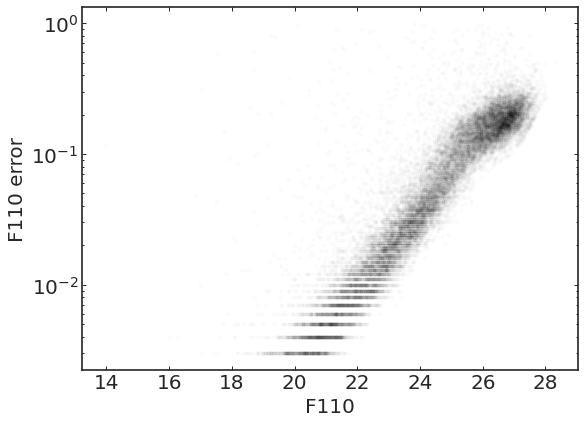

In [5]:
# visualize the measurements
filt = 'F110'
pd = pd110

plt.semilogy(pd[filt],pd[filt+'_er'],'k.',alpha=0.01)
plt.xlabel(filt)
plt.ylabel(filt+' error')

Time coefficient = -0.348+/-0.014
Time coefficient = -0.430+/-0.114
Time coefficient = -0.348+/-0.119


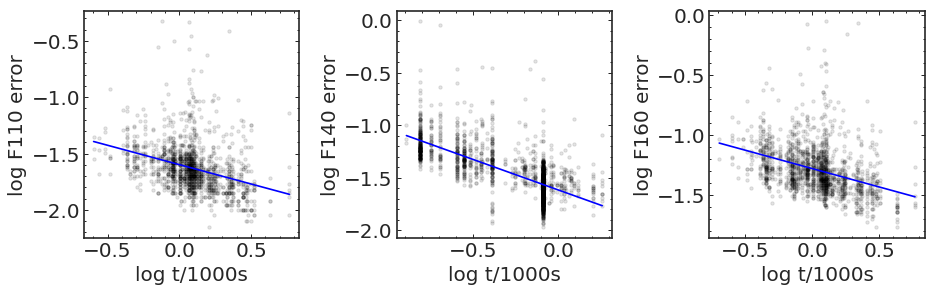

In [21]:
# Evaluate time dependence of series of small range of magnitudes
# use this to get the mean coeffecient for the time exponent
step= 0.5
mags = numpy.arange(22,24.01,step)
coeff=[]

t_coeffs={}
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for filt, a in zip(['F110', 'F140', 'F160'], ax):
    for m in mags:
        pd=None
        if filt=='F110':
            pd = pd110
        if filt=='F140':
            pd=pd140
        if filt=='F160':
            pd=pd160
        pds = pd[pd[filt]>m]
        pds = pds[pds[filt]<(m+step)]
        mask= numpy.isnan(pds['expt_{}w'.format(filt.lower())].values)
        x = numpy.log10(pds['expt_{}w'.format(filt.lower())]/tref).values[~mask]
        y = numpy.log10(pds[filt+'_er']).values[~mask]

        fit = numpy.polyfit(x,y,1)
        coeff.append(fit[0])
    #print(fit)
        if m == mags[int(0.5*len(mags))]:
            xp = numpy.linspace(numpy.nanmin(x),numpy.nanmax(x),100)
            a.plot(x,y,'k.',alpha=0.1)
            a.plot(xp,numpy.polyval(fit,xp),'b-')
            a.set_xlabel('log t/1000s')
            a.set_ylabel('log {} error'.format(filt))
            a.minorticks_on()
    #plt.semilogy(pd110s['F110'],pd110s['F110_er'],'k.')
    #plt.plot(mags,coeff)
    plt.tight_layout()
    t_coeffs[filt]=[numpy.median(coeff),numpy.std(coeff)]
    print('Time coefficient = {:.3f}+/-{:.3f}'.format(numpy.median(coeff),numpy.std(coeff)))
plt.savefig(wisps.OUTPUT_FIGURES+'/exptime_magerrorfits.jpeg', rasterized=True)

In [7]:
t_coeffs

{'F110': [-0.34825934107482936, 0.014399485103189929],
 'F140': [-0.4297747738627907, 0.11389384269033065],
 'F160': [-0.34825934107482936, 0.11928211821185924]}

In [8]:
# check the fits make sense
#plt.plot(mags,coeff)
#plt.plot(mags,mags*0+numpy.median(coeff))

In [9]:
unc_coeffs={}

magnitude offset = 5.483, power law coefficient = 0.254
magnitude offset = 14.184, power law coefficient = 0.260
magnitude offset = 4.383, power law coefficient = 0.251


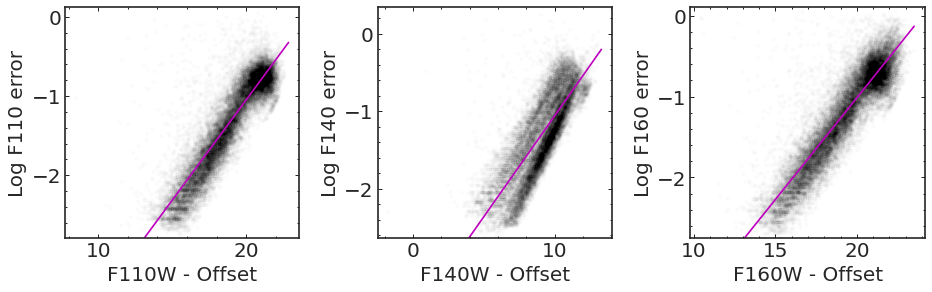

In [10]:
# using this time coefficient, fit the corrected log errors to linear magnitude trend
# iterate to get the zeropoint magnitude

fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for filt, a in zip(['F110', 'F140', 'F160'], ax):
    pd=None
    if filt=='F110':
        pd = pd110
    if filt=='F140':
        pd=pd140
    if filt=='F160':
        pd=pd160
    time_coeff = t_coeffs[filt][0]
    # be sure to put in appropriate one for each filter

    # initial fit without zeropoint
    mask= numpy.logical_or.reduce([numpy.isnan(pd['expt_{}w'.format(filt.lower())].values),
                            numpy.isnan(pd[filt+'_er'].values)])
    x0 = pd[filt]

    y0 = numpy.log10(pd[filt+'_er']*(pd['expt_{}w'.format(filt.lower())]/tref)**(-1.*time_coeff))
    xp = numpy.linspace(numpy.nanmin(x0),numpy.nanmax(x0),100)
    
    #print (x.values, x.values)

    fit0 = numpy.polyfit(x0[~mask],y0[~mask],1)
   
    # compute zero point from where log sigma = log sigma_min
    m0 = (numpy.log10(sigma_min)-fit[1])/fit[0]
    
   
    # refit and plot
    x = pd[filt]-m0
    y = numpy.log10(pd[filt+'_er']*(pd['expt_{}w'.format(filt.lower())]/tref)**(time_coeff))
    xp = numpy.linspace(numpy.nanmin(x),numpy.nanmax(x),100)
    
    #print (x.values, y.values)
    mask2= numpy.logical_or.reduce([numpy.isnan(x), numpy.isnan(y)])
    fit = numpy.polyfit(x[~mask2].values,y[~mask2].values,1)
    
    a.plot(x,y,'k.',alpha=0.01)
    a.plot(xp,numpy.polyval(fit,xp),'m-', alpha=1.)
    #a.plot(xp,numpy.polyval(fit0,xp),'m-')
    a.set_xlabel('{}W - Offset'.format(filt))
    a.set_ylabel('Log '+filt+' error')
    a.set_ylim([numpy.nanmin(y),numpy.nanmax(y)])
    print('magnitude offset = {:.3f}, power law coefficient = {:.3f}'.format(m0,fit[0]))
    unc_coeffs[filt]=[m0,time_coeff, fit[0], fit[1]]
    plt.tight_layout()
    a.minorticks_on()
plt.savefig(wisps.OUTPUT_FIGURES+'mag_magerrorfits.jpeg', rasterized=True)


In [11]:
total_coeffs= unc_coeffs
#for k in ['F110', 'F140', 'F160']:
#    total_coeffs[k]= numpy.concatenate([t_coeffs[k], unc_coeffs[k]])
#unc_coeffs

In [12]:
total_coeffs

{'F110': [5.482821544502133,
  -0.34825934107482936,
  0.2541179554241337,
  -6.127249561793502],
 'F140': [14.183849427315424,
  -0.4297747738627907,
  0.2597682343566299,
  -3.661393597261602],
 'F160': [4.3828101415133895,
  -0.34825934107482936,
  0.25131407450441007,
  -6.0405821934761095]}

In [13]:
10**-2.469

0.0033962527259040853

In [14]:
output_file='/volumes/LaCie/wispsdata/db//magnitude_cutoff.pkl'
pol=pandas.read_pickle(output_file)

In [15]:
pol['mag_unc_exp']=total_coeffs

In [16]:
#import pickle
#with open(output_file, 'wb') as file:
#    pickle.dump(pol,file)

In [17]:
pol

{'wisps': {'F110': (poly1d([ 1.20489888, 18.31086895]), 0.5038943667884174),
  'F140': (poly1d([ 1.49122797, 17.14118556]), 0.7495636144809823),
  'F160': (poly1d([ 1.36561328, 17.37352631]), 1.4165037712823727)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([-0.10025015, 22.66882951]), 0.21335391346949473),
  'F160': (poly1d([ 0.14320198, 21.86199263]), 0.22142403753971857)},
 'ncutoff': 50,
 'snr_exp': {'F110': array([-0.21776493,  0.4024389 ,  1.32173191]),
  'F140': array([-0.2388772 ,  0.22807276,  1.32815853]),
  'F160': array([-0.23620325,  0.39443396,  1.5334398 ])},
 'mag_unc_exp': {'F110': [5.482821544502133,
   -0.34825934107482936,
   0.2541179554241337,
   -6.127249561793502],
  'F140': [14.183849427315424,
   -0.4297747738627907,
   0.2597682343566299,
   -3.661393597261602],
  'F160': [4.3828101415133895,
   -0.34825934107482936,
   0.25131407450441007,
   -6.0405821934761095]},
 'F110': (poly1d([ 1.20489888, 18.31086895]), 0.5038943667884174),
 'F140': (poly1d([ 2.

In [27]:
#relabsmags=

In [24]:
relabsmags['F110W']

(poly1d([-1.01619437e-06,  1.77888727e-04, -1.25226734e-02,  4.55223050e-01,
        -9.04334157e+00,  9.36803491e+01, -3.86394331e+02]),
 0.3222664721637294)